<a href="https://colab.research.google.com/github/magnetbrains-bit/end-to-end-ml-pipeline-retail/blob/main/Retailrocket_recommender_system_dataset_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# This will prompt you to select a file.
# Choose the 'kaggle.json' file you just downloaded.
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajhimanshu24","key":"2a216160b78e247cd54f03850472c93a"}'}

In [ ]:
# Make a directory named ".kaggle"
!mkdir -p ~/.kaggle

# Copy the kaggle.json to the new directory
!cp kaggle.json ~/.kaggle/

# Set the permissions for the file to be read and written by only the owner
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d retailrocket/ecommerce-dataset

Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0
 97% 282M/291M [00:07<00:00, 29.1MB/s]
100% 291M/291M [00:07<00:00, 42.6MB/s]


In [ ]:
!unzip ecommerce-dataset.zip

Archive:  ecommerce-dataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


# Step 1: Load and Combine All Datasets

In [ ]:
# Cell 1: Load all data files and perform initial merge

import pandas as pd
import numpy as np

print("Loading data...")

# Load the main events file
# Note: For very large files, you might use dask or process in chunks. For now, Colab can handle this.
events_df = pd.read_csv('events.csv')

# Load the two item property files and concatenate them
item_props_df_part1 = pd.read_csv('item_properties_part1.csv')
item_props_df_part2 = pd.read_csv('item_properties_part2.csv')
item_props_df = pd.concat([item_props_df_part1, item_props_df_part2], ignore_index=True)

print("Data loaded successfully.")
print(f"Events data shape: {events_df.shape}")
print(f"Item properties data shape: {item_props_df.shape}")

# --- Initial Cleaning and Merging ---

# Convert timestamp to datetime objects
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# We only need the most recent property for each item. Let's find it.
# This is a common data preparation step.
item_props_df['timestamp'] = pd.to_datetime(item_props_df['timestamp'], unit='ms')
latest_props = item_props_df.loc[item_props_df.groupby('itemid')['timestamp'].idxmax()]

# Merge events with the latest item properties
# We use a 'left' join to keep all events, even if an item has no properties.
merged_df = pd.merge(events_df, latest_props[['itemid', 'property', 'value']], on='itemid', how='left')

print("\nData after merging:")
print(merged_df.head())

Loading data...
Data loaded successfully.
Events data shape: (2756101, 5)
Item properties data shape: (20275902, 4)

Data after merging:
                timestamp  visitorid event  itemid  transactionid property  \
0 2015-06-02 05:02:12.117     257597  view  355908            NaN      400   
1 2015-06-02 05:50:14.164     992329  view  248676            NaN      888   
2 2015-06-02 05:13:19.827     111016  view  318965            NaN      NaN   
3 2015-06-02 05:12:35.914     483717  view  253185            NaN      227   
4 2015-06-02 05:02:17.106     951259  view  367447            NaN        0   

                                               value  
0                    n552.000 639502 n720.000 424566  
1                                      857982 961511  
2                                                NaN  
3                                            1055600  
4  119932 754228 801383 471403 801383 693640 9860...  


# Step 2: Define the Feature Engineering Logic

In [ ]:
# Cell 2: Feature Engineering Function

def create_features(events, end_date):
    """
    Creates features for each visitorid based on their activity up to end_date.
    """
    # Filter events up to the specified end date
    df = events[events['timestamp'] <= end_date].copy()

    # Aggregate features for each visitor
    features = df.groupby('visitorid').agg(
        # Frequency features
        total_events=('event', 'count'),
        num_views=('event', lambda x: (x == 'view').sum()),
        num_addtocart=('event', lambda x: (x == 'addtocart').sum()),
        num_transactions=('event', lambda x: (x == 'transaction').sum()),

        # Engagement features
        num_unique_items=('itemid', 'nunique'),

        # Recency feature: days since last event
        last_event_ts=('timestamp', 'max')
    ).reset_index()

    # Calculate recency in days from the end_date
    features['days_since_last_event'] = (end_date - features['last_event_ts']).dt.days
    features = features.drop(columns=['last_event_ts'])

    # Create interaction features
    features['add_to_cart_rate'] = features['num_addtocart'] / features['num_views']
    features['buy_rate'] = features['num_transactions'] / features['total_events']

    # Handle potential division by zero
    features.fillna(0, inplace=True)

    return features

print("Feature engineering function created.")

Feature engineering function created.


# Step 3: Define the Target Variable Creation Logic

In [ ]:
# Cell 3: Target Variable Function

def create_target(events, users, start_date, end_date):
    """
    Creates a target variable for each user.
    Target is 1 if the user had a transaction between start_date and end_date.
    """
    # Find all transactions within the target window
    target_window = events[(events['timestamp'] > start_date) & (events['timestamp'] <= end_date)]
    transactions = target_window[target_window['event'] == 'transaction']

    # Get the unique visitors who made a transaction
    buyers = transactions['visitorid'].unique()

    # Create the target column
    users['target'] = users['visitorid'].isin(buyers).astype(int)

    return users

print("Target variable creation function created.")

Target variable creation function created.


# Step 4: Chronological Split and Data Assembly

In [ ]:
# Cell 4: Create Training and Testing Sets

from datetime import timedelta

# -- Define our time windows --
# We will use data up to August 15th to train the model.
train_end_date = pd.to_datetime('2015-08-15')

# We want to predict who will buy in the following week.
train_target_start_date = train_end_date
train_target_end_date = train_end_date + timedelta(days=7)

# Our test set will be features calculated up to August 22nd...
test_end_date = train_target_end_date
# ...to predict who will buy in the week after that.
test_target_start_date = test_end_date
test_target_end_date = test_end_date + timedelta(days=7)

print(f"Training features up to: {train_end_date}")
print(f"Training target window: {train_target_start_date} to {train_target_end_date}")
print(f"Test features up to: {test_end_date}")
print(f"Test target window: {test_target_start_date} to {test_target_end_date}")

# --- Create Training Set ---
print("\nCreating training set...")
X_train_features = create_features(merged_df, train_end_date)
X_train = create_target(merged_df, X_train_features, train_target_start_date, train_target_end_date)
y_train = X_train.pop('target')
X_train = X_train.set_index('visitorid') # Set index for easy lookup

# --- Create Test Set ---
print("Creating test set...")
X_test_features = create_features(merged_df, test_end_date)
X_test = create_target(merged_df, X_test_features, test_target_start_date, test_target_end_date)
y_test = X_test.pop('target')
X_test = X_test.set_index('visitorid')

# Align columns - crucial if some features don't appear in one set
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Positive cases in training set: {(y_train == 1).sum()}")
print(f"Positive cases in test set: {(y_test == 1).sum()}")

Training features up to: 2015-08-15 00:00:00
Training target window: 2015-08-15 00:00:00 to 2015-08-22 00:00:00
Test features up to: 2015-08-22 00:00:00
Test target window: 2015-08-22 00:00:00 to 2015-08-29 00:00:00

Creating training set...
Creating test set...

Training data shape: (1095383, 8)
Test data shape: (1160616, 8)
Positive cases in training set: 127
Positive cases in test set: 131


# Step 5: Train and Evaluate the Model

Training XGBoost model...
Model training complete.

Evaluating model on the test set...
ROC AUC Score: 0.6059
F1 Score: 0.0006
Precision: 0.0003
Recall: 0.2977

Confusion Matrix:


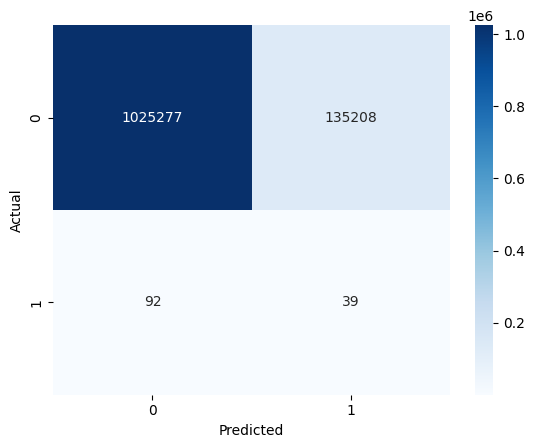

In [ ]:
# Cell 5: Model Training and Evaluation

import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Training XGBoost model...")

# Handle potential infinite values in the data
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)


# The data is imbalanced, so we use scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)
print("Model training complete.")

# --- Evaluate the Model ---
print("\nEvaluating model on the test set...")
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred_proba > 0.5).astype(int) # Using a 0.5 threshold for now

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f"ROC AUC Score: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Save the Final Artifacts

In [ ]:
# Cell 6: Save Model and Feature List

import joblib
import json

print("Saving model and feature list...")

# Save the model
joblib.dump(model, 'propensity_to_buy_model.pkl')

# Save the feature list
features_list = X_train.columns.tolist()
with open('features.json', 'w') as f:
    json.dump(features_list, f)

print("Artifacts saved successfully!")
print("You can now download 'propensity_to_buy_model.pkl' and 'features.json' from the file browser on the left.")

Saving model and feature list...
Artifacts saved successfully!
You can now download 'propensity_to_buy_model.pkl' and 'features.json' from the file browser on the left.
